In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import btb.utils.tools as btbtools
import btb.utils.wikiquery as wq

import mwclient
import pickle
from collections import defaultdict

In [3]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [4]:
from IPython.display import Image

In [5]:
wikiEN = mwclient.Site('en.wikipedia.org')
# wikiEN = btbtools.getDebugWiki()
bots = wq.getAllBots(wikiEN)
expEdPct = wq.getTotalContributions() # Expected percentage of edits per country

In [6]:
def randomTitles(wikiEN, nTitles):
    '''
    Generator of random Wikipedia pages.
    '''
    for i in range(int(nTitles/10)):
        randPages = wikiEN.random(namespace=0, limit=10)
        for page in randPages:
            yield page['title']

In [7]:
def categoryTitles(wikiEN, catName, nTitles):
    '''
    Generator of random Wikipedia pages in a category.
    
    NOTE: ordering of items in the category is always the same.
    
    eg: categoryTitles(wikiEN, 'Cities in the Netherlands', 20)
    '''
    wikiCat = wikiEN.categories[catName]
    for i in range(nTitles):
        catPage = wikiCat.next()
        yield catPage.name

In [14]:
def unpackContributions(cmpEdits):
    ''' previously dict comprehension: 
    { ctry: ac for ctry,(ex,ac,cm) in cmpEdits.iteritems() } 
    
    except added an if  to avoid empty keys which cause problems 
    when pickling '''
    edits = {}
    for ctry,(ex,ac,cm) in cmpEdits.iteritems():
        if ctry=='':
            ctry = '_'
        edits[ctry] = ac
    return edits

def fetchContributions(titles):
    '''
    Parameters:
        titles    Generator of titles to be fetched
    Return:
        dictionary of title: contribution percentages
    '''
    # TODO: Maybe make into a generator ?
    cumEdCount = []
    for pageTitle in titles:
        ips, usrs, nrevs = wq.getContributionsForPage(wikiEN, pageTitle)
        revCount, conf, nIP, nUsr, nBot, nUnkn = btbtools.prepareData(ips, usrs, bots)

        #cmpEdits = btbtools.compareEdits(expEdPct, revCount)
        #actEdPct = unpackContributions(cmpEdits)
        #cumEdPct.append((pageTitle, actEdPct))
        cumEdCount.append((pageTitle, revCount))
    return cumEdCount

In [16]:
def getContributionSummary(pageContribs):
    # Normalization factor:
    # Weight each contribution by a normalization factor dependent on the 
    # total weight of all contributions
    normFactor = sum( sum(contribs.values()) for title,contribs in pageContribs )
    
    edPct = defaultdict(float)
    for title,pageEdPct in pageContribs:
        for ctry,pct in pageEdPct.iteritems():
            edPct[ctry] += pct / normFactor
    edPct = dict(edPct)
    return edPct


In [17]:
def getEditError(globalContribs):
    editDiff = []
    for e in expEdPct:
        ex = expEdPct[e]
        ac = globalContribs[e] if e in globalContribs else 0
        editDiff.append(ac-ex)
    editDiff = np.array(editDiff)
    return (editDiff**2).sum()

In [20]:
titles = randomTitles(wikiEN, 20)
pageContribs = fetchContributions(titles)

[  83.632966     42.334966     28.856966     31.722966     30.392166
   26.762966     49.382966     43.231966     38.89007711   38.273766
   34.90987509   43.82379933   41.39358138   42.95910886   40.10683267
   41.274091    152.61437776  144.86307711  137.298966    131.126366  ]


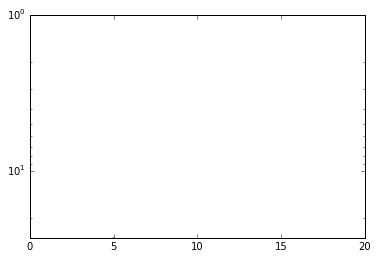

In [30]:
plotContribError(pageContribs)
#figure()
#plotHistogramContributions(pageContribs)
#buildAnimation(pageContribs, 'PageContribsRandom1000B.gif', duration=20)
#Image(url='PageContribsRandom1000B.gif')

# Fetch data from Wikipedia

In [ ]:
titles = randomTitles(wikiEN, 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom.pkl', 'w'))

In [ ]:
titles = categoryTitles(wikiEN, 'Cities in the Netherlands', 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribs_citiesNL.pkl', 'w'))

In [ ]:
titles = randomTitles(wikiEN, 1000)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom1000A.pkl', 'w'))

In [ ]:
titles = randomTitles(wikiEN, 1000)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom1000B.pkl', 'w'))

# Plot data

In [29]:
#def getErr(pageContribs, n):
#    contribsN = pageContribs[:n]
#    return getEditError(getContributionSummary(contribsN))

#def plotContribError(pageContribs):
#    nSamples = range(1,len(pageContribs))
#    err = [ getErr(pageContribs, n_i) for n_i in nSamples ]
#    semilogy(nSamples,err)
#    axis([ 0, len(pageContribs), 0, 1]);

def getErr(pageContribs, n):
    pageTitle,pageContribs = pageContribs[n]
    return getEditError(pageContribs)

def plotContribError(pageContribs):
    nSamples = arange(0,len(pageContribs))
    err = np.array([ getErr(pageContribs, n_i) for n_i in nSamples ])
    err = err.cumsum() / (nSamples+1)
    semilogy(nSamples,err)
    axis([ 0, len(pageContribs), 0, 1]);
    print err

# TODO: speed up plot contrib error...

In [169]:
pageContribs = pickle.load(open('PageContribsRandom1000B.pkl', 'r'))

1 loops, best of 3: 8.62 s per loop


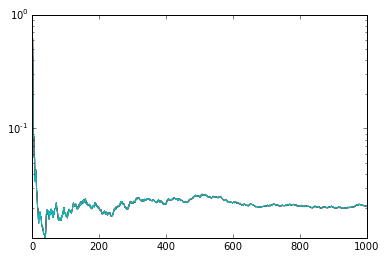

In [73]:
%%timeit
plotContribError(pageContribs)

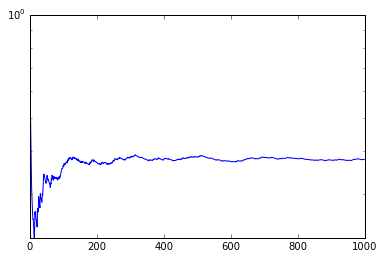

In [196]:


#plotContribError(pageContribs)
#plotContribError2(pageContribs)



The slowest run took 4.54 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 14 ms per loop


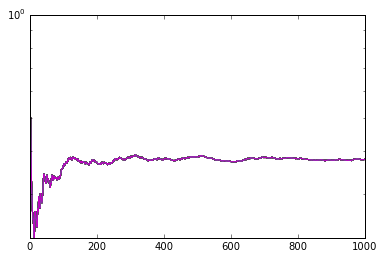

In [197]:
%%timeit
plotContribError2(pageContribs)

In [ ]:
def getEditError(globalContribs):
    editDiff = []
    for e in expEdPct:
        ex = expEdPct[e]
        ac = globalContribs[e] if e in globalContribs else 0
        editDiff.append(ac-ex)
    editDiff = np.array(editDiff)
    return (editDiff**2).sum()

pageTitle,contribs = pageContribs[120]
pageTitle,pageContribs
# pageContribs[120]

In [22]:
def plotHistogramContributions(pageContribs, fig=None):
    if fig==None:
        figure(figsize=(12,4))

    actEdPct = getContributionSummary(pageContribs)

    tags   = np.array(expEdPct.keys())
    cmpVals = np.array(expEdPct.values())

    # Sort descending by expected value
    sortIdx = cmpVals.argsort()
    sortIdx = sortIdx[::-1]
    tags   = tags[sortIdx]

    expVal = [ expEdPct[ctry] for ctry in tags ]
    actVal = [ actEdPct[ctry] for ctry in tags ]

    # Format bar charts
    width = 0.35
    N = len(tags)
    ind = np.arange(N)

    bar(ind           , expVal, width=width, color='y', label='Expectation')
    bar(ind + width   , actVal, width=width, color='r', label='Contribution')
    xticks(ind + width, tags  , rotation=90)

In [23]:
def makeFrame(i, pageContribs):
    gcf().clear()
    plotHistogramContributions(pageContribs[:i], gcf())
    title('Title %d'%i)
    img = mplfig_to_npimage(gcf())
    return img

def wrapMakeFrame(f, pageContribs, fps):
    i = int(f * fps)+1
    #print 'F: ', f, ' -> ', i
    return makeFrame(i, pageContribs)

def buildAnimation(pageContribs, aniFile, duration):
    fps = len(pageContribs) / duration
    print 'We have to display %f frames each second, so in %d seconds, we display %d frames'%(fps, duration, len(pageContribs))
    
    fig = figure(figsize=(12,4))
    
    lambdaMakeFrame = lambda f: wrapMakeFrame(f, pageContribs, fps)

    trueFps = fps if fps<24 else 24
    animation =mpy.VideoClip(lambdaMakeFrame, duration=duration)
    animation.write_gif(aniFile, fps=trueFps)
    close()

## 500 random Wikipedia pages

In [120]:
pageContribs = pickle.load(open('PageContribsRandom.pkl', 'r'))

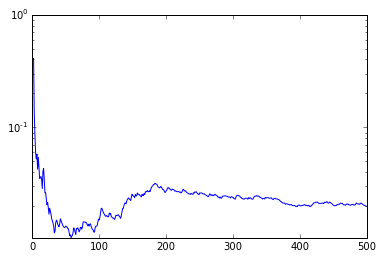

In [15]:
plotContribError(pageContribs)

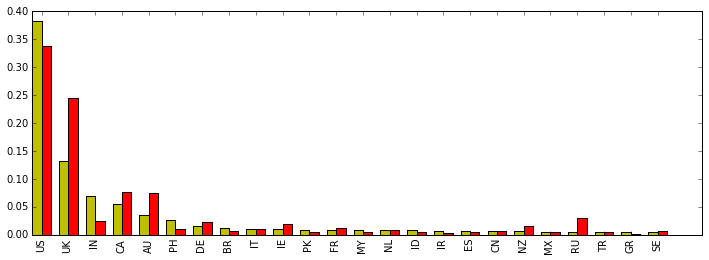

In [16]:
plotHistogramContributions(pageContribs)

In [17]:
buildAnimation(pageContribs, 'random.gif', duration=50)

We have to display 10.000000 frames each second, so in 50 seconds, we display 500 frames

[MoviePy] Building file random.gif with imageio


In [25]:
Image(url='random.gif')

## Category: cities in the netherlands

In [122]:
pageContribs = pickle.load(open('PageContribs_citiesNL.pkl', 'r'))

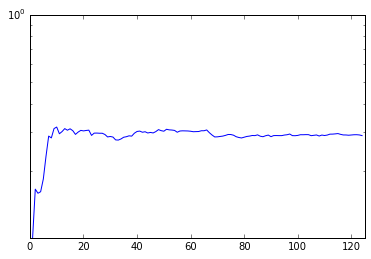

In [123]:
plotContribError(pageContribs)

In [ ]:
buildAnimation(pageContribs, 'cities_nl.gif', duration=20)

In [26]:
Image(url='cities_nl.gif')

In [125]:
pageContribs = pickle.load(open('PageContribsRandom1000A.pkl', 'r'))

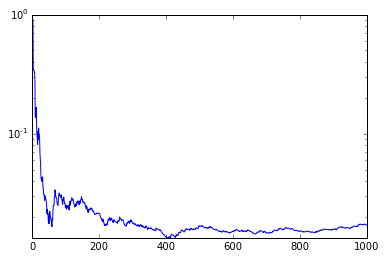

In [41]:
plotContribError(pageContribs)

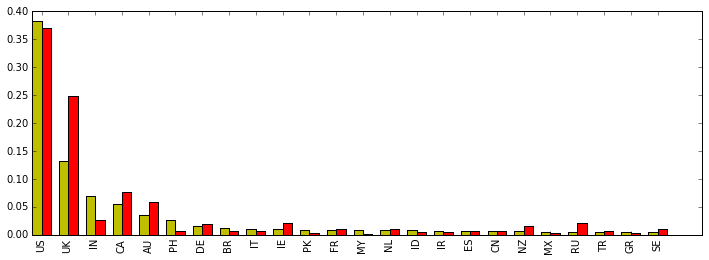

In [42]:
plotHistogramContributions(pageContribs)

In [43]:
buildAnimation(pageContribs, 'PageContribsRandom1000A.gif', duration=20)
Image(url='PageContribsRandom1000A.gif')

We have to display 50.000000 frames each second, so in 20 seconds, we display 1000 frames

[MoviePy] Building file PageContribsRandom1000A.gif with imageio


We have to display 50.000000 frames each second, so in 20 seconds, we display 1000 frames

[MoviePy] Building file PageContribsRandom1000B.gif with imageio


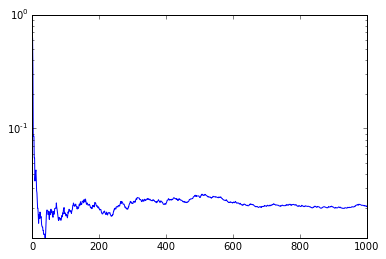

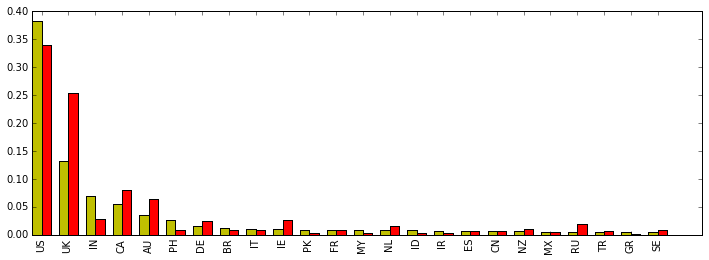

In [44]:
pageContribs = pickle.load(open('PageContribsRandom1000B.pkl', 'r'))
figure()
plotContribError(pageContribs)
figure()
plotHistogramContributions(pageContribs)
buildAnimation(pageContribs, 'PageContribsRandom1000B.gif', duration=20)
Image(url='PageContribsRandom1000B.gif')

We have to display 50.000000 frames each second, so in 20 seconds, we display 1000 frames

[MoviePy] Building file PageContribsRandom1000C.gif with imageio


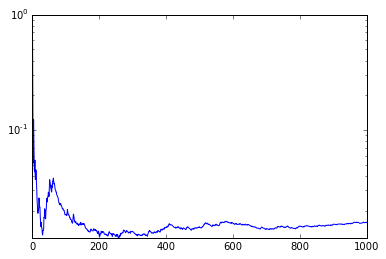

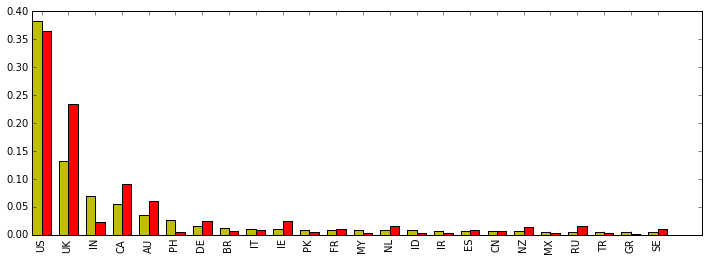

In [45]:
pageContribs = pickle.load(open('PageContribsRandom1000C.pkl', 'r'))
figure()
plotContribError(pageContribs)
figure()
plotHistogramContributions(pageContribs)
buildAnimation(pageContribs, 'PageContribsRandom1000C.gif', duration=20)
Image(url='PageContribsRandom1000C.gif')

We have to display 50.000000 frames each second, so in 20 seconds, we display 1000 frames

[MoviePy] Building file PageContribsRandom1000D.gif with imageio


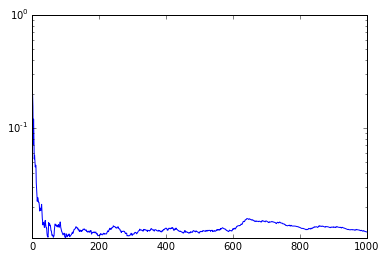

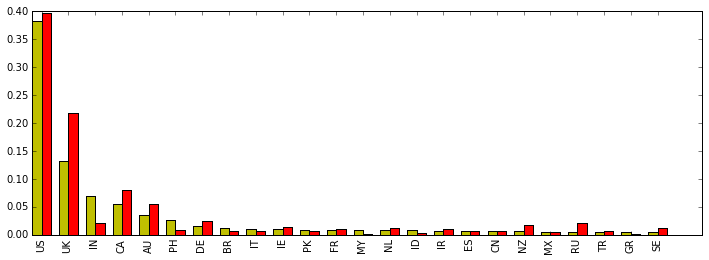

In [46]:
pageContribs = pickle.load(open('PageContribsRandom1000D.pkl', 'r'))
figure()
plotContribError(pageContribs)
figure()
plotHistogramContributions(pageContribs)
buildAnimation(pageContribs, 'PageContribsRandom1000D.gif', duration=20)
Image(url='PageContribsRandom1000D.gif')

We have to display 50.000000 frames each second, so in 20 seconds, we display 1000 frames

[MoviePy] Building file PageContribsRandom1000E.gif with imageio


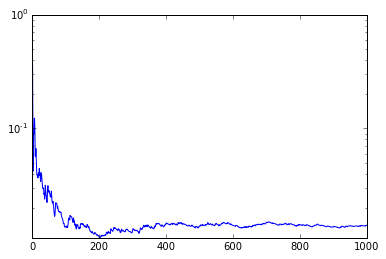

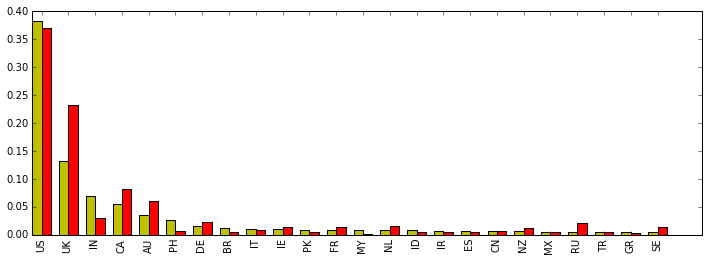

In [47]:
pageContribs = pickle.load(open('PageContribsRandom1000E.pkl', 'r'))
figure()
plotContribError(pageContribs)
figure()
plotHistogramContributions(pageContribs)
buildAnimation(pageContribs, 'PageContribsRandom1000E.gif', duration=20)
Image(url='PageContribsRandom1000E.gif')

In [48]:
!ls PageContribsRandom1000*.pkl

PageContribsRandom1000A.pkl  PageContribsRandom1000C.pkl  PageContribsRandom1000E.pkl
PageContribsRandom1000B.pkl  PageContribsRandom1000D.pkl


In [49]:
from glob import glob

In [133]:
pageContribs = []
allTitles = set()

for filename in glob('PageContribsRandom1000*.pkl'):
    pklData = pickle.load(open(filename, 'r'))
    for pageTitle,dist in pklData:
        if pageTitle in allTitles:
            print 'Repeated: ',pageTitle
        else:
            allTitles.add(pageTitle)
            pageContribs.append((pageTitle,dist))
    

Repeated:  Stambolov Crag
Repeated:  List of awards and nominations received by Vanessa Redgrave
Repeated:  Back Off Cupids
Repeated:  Tony Brown (defensive back, b. 1970)
Repeated:  Bishwa Ijtema
Repeated:  Chepo expedition
Repeated:  Liam Bates
Repeated:  Malheur National Forest
Repeated:  Sheikh Mukhtar
Repeated:  Holly Flax
Repeated:  Susanna
Repeated:  Matteo Contini


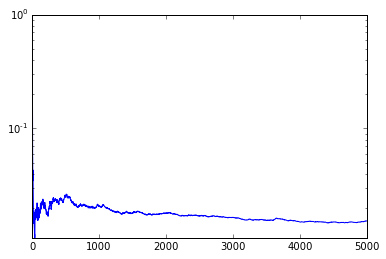

In [61]:
plotContribError(pageContribs)

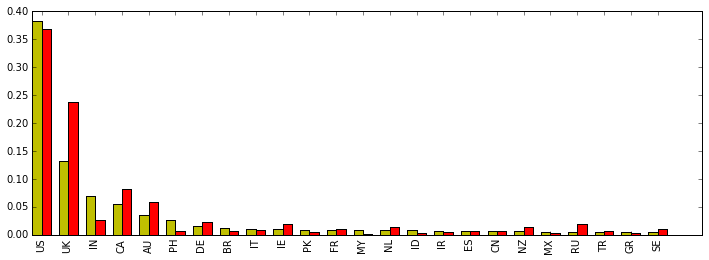

In [62]:
plotHistogramContributions(pageContribs)

In [70]:
buildAnimation(pageContribs, 'PageContribsRandom-all.gif', duration=20)
Image(url='PageContribsRandom-all.gif')

We have to display 250.000000 frames each second, so in 20 seconds, we display 5000 frames

[MoviePy] Building file PageContribsRandom-all.gif with imageio


In [168]:
allBritish = []
n = 0
for pageTitle, contribs in pageContribs:
    if contribs['UK']>0.15:
        n += 1
        allBritish.append(pageTitle)
print n/len(pageContribs)


0.378949710725 3406


In [142]:
allBritish

[u'1895 Minor Counties Championship',
 u'Megachile chrysopygopsis',
 u"St Helen's Church, Abingdon",
 u"King's Statue",
 u'White Cross, Cornwall',
 u'Peppered flounder',
 u'Northern Mariana Islands integration referendum, 1963',
 u'Leptospira fainei',
 u'Villiers-sur-Chiz\xe9',
 u'Koman Hydroelectric Power Station',
 u'Kebun Baru Single Member Constituency',
 u'Heaphy Spur',
 u'Bobby Atherton',
 u'Los Banos Unified School District',
 u'Bronwenia',
 u'Luzocephalus',
 u'Rudolf K\xe4mpf',
 u"2012 Wake Forest Demon Deacons men's soccer team",
 u'Tschaggunser Mittagspitze',
 u"Bernard N'Nomo",
 u'Mendi (disambiguation)',
 u'Jos\xe9 Ortiz (athlete)',
 u'Government House, Montserrat',
 u'Neocollyris prominens',
 u'James C. Milliman',
 u'Moses Chayyim Catalan',
 u'Ilsebill',
 u'6413 Iye',
 u'Le Pin-en-Mauges',
 u'Hotedr\u0161ica',
 u'Wilfred Carter',
 u'Henning Matzen',
 u'Adeuomphalus trochanter',
 u'Euphemia of Greater Poland (1253\u20131298)',
 u'Bernhard Friedmann',
 u'Upper Common Pits',


In [ ]:
totalRevs = []
for pageTitle in allBritish:
    ips, usrs, nrevs = wq.getContributionsForPage(wikiEN, pageTitle)
    #revCount, conf, nIP, nUsr, nBot, nUnkn = btbtools.prepareData(ips, usrs, bots)
    print '%4d for %s '%(nrevs, pageTitle)

15.097560975609756

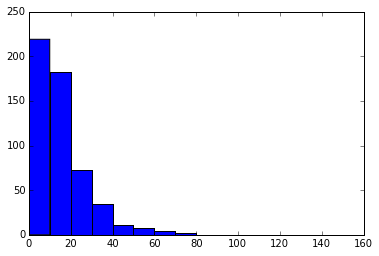

In [163]:
britishRevs = [ 5 , 4 , 29 , 12 , 15 , 19 , 3 , 11 , 28 , 27 , 7 , 9 , 29 , 5 , 8 , 11 , 18 , 5 , 6 , 13 , 4 , 
               2 , 11 , 8 , 8 , 12 , 6 , 18 , 27 , 21 , 28 , 15 , 12 , 11 , 10 , 9 , 13 , 23 , 9 , 9 , 14 , 
               13 , 8 , 26 , 5 , 30 , 18 , 14 , 1 , 3 , 36 , 5 , 5 , 5 , 6 , 12 , 23 , 6 , 6 , 17 , 6 , 26 , 
               32 , 11 , 19 , 35 , 10 , 8 , 11 , 10 , 17 , 13 , 17 , 35 , 14 , 25 , 15 , 6 , 12 , 21 , 2 , 9 , 
               8 , 22 , 7 , 10 , 21 , 14 , 28 , 4 , 24 , 13 , 6 , 17 , 32 , 3 , 36 , 11 , 6 , 37 , 7 , 17 , 
               57 , 10 , 12 , 9 , 8 , 16 , 10 , 8 , 35 , 12 , 8 , 9 , 16 , 14 , 9 , 10 , 4 , 13 , 10 , 14 , 
               4 , 9 , 3 , 2 , 13 , 13 , 9 , 19 , 3 , 28 , 32 , 19 , 3 , 46 , 3 , 13 , 16 , 12 , 7 , 14 , 
               28 , 11 , 50 , 5 , 9 , 23 , 3 , 7 , 3 , 18 , 27 , 6 , 22 , 8 , 22 , 14 , 8 , 6 , 14 , 27 , 
               9 , 41 , 6 , 19 , 4 , 11 , 24 , 10 , 10 , 32 , 24 , 6 , 13 , 54 , 7 , 2 , 11 , 11 , 6 , 19 , 
               9 , 18 , 10 , 12 , 5 , 13 , 7 , 39 , 8 , 51 , 9 , 9 , 18 , 17 , 21 , 12 , 24 , 36 , 6 , 2 , 
               41 , 6 , 6 , 12 , 20 , 10 , 23 , 13 , 22 , 31 , 2 , 14 , 14 , 6 , 9 , 7 , 38 , 25 , 11 , 19 , 
               25 , 3 , 16 , 11 , 18 , 32 , 5 , 17 , 12 , 10 , 14 , 3 , 16 , 9 , 14 , 12 , 4 , 11 , 14 , 3 , 
               7 , 11 , 37 , 33 , 5 , 7 , 7 , 5 , 6 , 7 , 11 , 14 , 49 , 16 , 3 , 7 , 10 , 5 , 4 , 7 , 5 , 4 , 
               26 , 14 , 3 , 3 , 37 , 7 , 12 , 25 , 29 , 6 , 4 , 10 , 64 , 22 , 32 , 39 , 7 , 9 , 9 , 25 , 2 , 
               7 , 44 , 6 , 14 , 16 , 9 , 12 , 27 , 18 , 18 , 67 , 11 , 16 , 4 , 8 , 3 , 40 , 1 , 45 , 11 , 15 , 
               19 , 22 , 11 , 6 , 16 , 26 , 18 , 3 , 15 , 11 , 53 , 15 , 10 , 6 , 30 , 6 , 16 , 7 , 8 , 5 , 7 , 
               10 , 9 , 16 , 3 , 4 , 7 , 11 , 49 , 10 , 9 , 23 , 4 , 22 , 8 , 8 , 16 , 4 , 12 , 9 , 19 , 50 , 
               20 , 8 , 18 , 10 , 26 , 9 , 8 , 8 , 7 , 10 , 3 , 12 , 11 , 8 , 21 , 16 , 13 , 6 , 35 , 31 , 3 , 
               3 , 28 , 14 , 17 , 41 , 11 , 47 , 14 , 24 , 19 , 22 , 7 , 16 , 11 , 9 , 19 , 14 , 16 , 20 , 29 , 
               11 , 8 , 65 , 26 , 8 , 4 , 11 , 2 , 5 , 27 , 8 , 4 , 5 , 14 , 65 , 3 , 25 , 27 , 17 , 33 , 18 , 
               8 , 4 , 16 , 6 , 3 , 7 , 30 , 9 , 37 , 3 , 34 , 8 , 7 , 8 , 4 , 4 , 18 , 3 , 20 , 4 , 13 , 12 , 
               15 , 1 , 23 , 19 , 7 , 19 , 3 , 43 , 18 , 2 , 12 , 8 , 28 , 21 , 23 , 3 , 6 , 27 , 17 , 53 , 
               6 , 2 , 31 , 12 , 4 , 17 , 32 , 3 , 16 , 26 , 9 , 13 , 8 , 4 , 19 , 22 , 22 , 11 , 8 , 4 , 4 , 
               23 , 4 , 20 , 8 , 8 , 3 , 24 , 6 , 9 , 32 , 37 , 15 , 19 , 14 , 3 , 6 , 4 , 11 , 52 , 17 , 78 , 
               8 , 7 , 5 , 33 , 10 , 22 , 4 , 12 , 12 , 3 , 5 , 12 , 18 , 6 , 19 , 3 , 1 , 28 , 21 , 9 , 6 , 
               14 , 22 , 5 , 73 , 9 , 6 , 15 , 3 , 3 , 16 , 23 , 35 , 8 , 22 , 8 , 19 , 10 , 4 ] 

hist(britishRevs, bins=arange(0,160,10));
np.mean(britishRevs)

In [161]:
totalRevs = []
for i in np.random.randint(0,len(pageContribs), 150):
    pageTitle, contribs = pageContribs[i]
    ips, usrs, nrevs = wq.getContributionsForPage(wikiEN, pageTitle)
    totalRevs.append(nrevs)

67.833333333333329

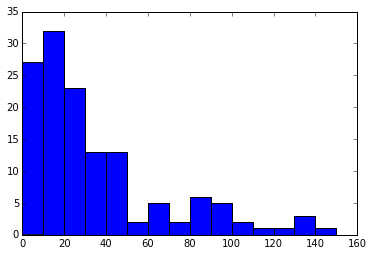

In [162]:
hist(totalRevs, bins=arange(0,160,10));
np.mean(totalRevs)

In [166]:
#contribs,pageTitle
nrevs

8